In [2]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2
import dask.dataframe as dd
import dask.array as da
import itertools

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
logger.addHandler(logging.FileHandler('Logs/pairsim_{0}.log'.format(datetime.datetime.now().\
                                                            strftime("%Y-%m-%d"), 'a')))
print = logging.info
print('good day to you madam fiona')
print('started')
print(datetime.datetime.now())

INFO:root:good day to you madam fiona
INFO:root:started
INFO:root:2018-07-23 12:51:18.934573


## 1. Similarity

See helpful code here: https://stackoverflow.com/questions/3992735/python-generator-that-groups-another-iterable-into-groups-of-n

In [3]:
def grouper(n, iterable):
    """
    >>> list(grouper(3, 'ABCDEFG'))
    [['A', 'B', 'C'], ['D', 'E', 'F'], ['G']]
    """
    iterable = iter(iterable)
    return iter(lambda: list(itertools.islice(iterable, n)), [])


In [ ]:
import scipy.spatial.distance as distance
dms = ["ldavecs", "docvecs"]
files = ["DataStore/2018-07-P2/Software/computer_sw_samp_0723.pkl"]
out_files = ["DataStore/2018-07-P2/Software/computer_sw_sim_0723.pkl"]

for i,f in enumerate(files):
    print("Loading sample data")
    print(f)
    # 1. Load data
    l2 = pd.read_pickle(f)
    l2 = l2.drop_duplicates()
    print(len(l2))
    for dm in dms:
        print("Loading matrix and dict")
        print(datetime.datetime.now())

        pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
        pat_dict = dict(zip(pat_dict, range(len(pat_dict))))
        # Store as dask array
        if dm == "ldavecs":
            ncols = 60
        else:
            ncols = 100
        pm = dd.read_parquet("DataStore/2018-07-P2/ML/{0}_pats_0712.parq".format(dm)).values.compute()
        pm = da.from_array(pm, chunks=(10000,ncols))

        print("Getting row values")
        print(datetime.datetime.now())
        #----------#
        # 2. Get pat vecs & pat similarity
        print(len(l2))
        # Remove missing values
        l3 = l2[["tp", "op"]].loc[l2["tp"].isin(pat_dict.keys()) & l2["op"].isin(pat_dict.keys())]

        if dm == "ldavecs":
            ncols = 60
        else:
            ncols = 100
        print(len(l3))

        print("Getting chunks")
        print(datetime.datetime.now())
        # Split into chunks
        n_rows = 3000
        n_chunks = int(np.round(len(l3)/n_rows))
        tp_chunks = grouper(n_rows, pm[[pat_dict[p] for p in l3["tp"].tolist()]].compute())
        op_chunks = grouper(n_rows, pm[[pat_dict[p] for p in l3["op"].tolist()]].compute())
        chunks = itertools.zip_longest(tp_chunks, op_chunks)

        print("Getting patent pair similarity")
        print("cosine")
        print(datetime.datetime.now())
        # Cosine

        cos_dis = np.empty(len(l3))

        for r, c in enumerate(chunks):
            cos_dis[r*n_rows:r*n_rows+n_rows] = np.diag(distance.cdist(c[0],c[1], metric = "cosine"))

        l3["sim_{0}".format(dm)] = 1-cos_dis
        del(cos_dis)

        l2 = l2.merge(l3[["tp", "op", "sim_{0}".format(dm)]], how = "left", on = ["tp", "op"])
        print(len(l2))           
        print("Finished {0}".format(dm))
        print(datetime.datetime.now())
    l2 = l2.drop_duplicates()
    print(len(l2))
    l2.to_pickle(out_files[i])
    

INFO:root:Loading sample data
INFO:root:DataStore/2018-07-P2/Software/computer_sw_samp_0723.pkl
INFO:root:1203822
INFO:root:Loading matrix and dict
INFO:root:2018-07-23 13:09:11.888595


In [43]:
tr_out = ["DataStore/2018-07-P2/Software/computer_sw_transformed_0723.pkl"]
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                                    ["patent", "appyear", "gyear", "naics_name", "primclass", "inv_msa"]).drop_duplicates("patent")
sw_pats = pd.read_pickle("DataStore/2018-07-P2/Software/sw_pats.pkl")
ts = pd.read_pickle(out_files[0])    
ts = ts.merge(pdf.add_prefix("tp_"), how = "left", left_on="tp", right_on="tp_patent").drop("tp_patent",1)
print(len(ts))
ts = ts.merge(pdf.add_prefix("op_"), how = "left", left_on="op", right_on="op_patent").drop("op_patent",1)
print(len(ts))
del(pdf)
# Add year diff
ts["year_diff"] = ts["op_appyear"] - ts["tp_appyear"]
# Add if software
ts["tp_is_sw"] = ts["op_is_sw"] = False
ts.loc[ts["tp"].isin(sw_pats.tolist()), "tp_is_sw"] = True
ts.loc[ts["op"].isin(sw_pats.tolist()), "op_is_sw"] = True

for c in ["naics_name", "primclass", "inv_msa"]:
    ts["{0}_match".format(c)] = (ts["tp_{0}".format(c)] == ts["op_{0}".format(c)])

# eps = 0.01
# dv_min = 0.7
# def scale_docvecs(x):
#     scaled = ((x+dv_min)/(1+dv_min))*(1-eps)+eps
#     return scaled
# def scale_ldavecs(x):
#     scaled = x*(1-eps)+eps
#     return scaled
# ts["sim_ldavecs"] = ts["sim_ldavecs"].apply(scale_ldavecs)
# ts["sim_docvecs"] = ts["sim_docvecs"].apply(scale_docvecs)

ts.to_pickle(tr_out[0])



INFO:root:1203822
INFO:root:1203822


____

## 2. Software patent similarity

1. Average similarity for all target patents for (i) in MSA and (ii) in Field
2. Plot Not Samp target patents similarity to the "in field" sample
3. Plot Samp target patents similarity to the "in field" sample
4. For each year, Get difference of 2 & 3; also p-value of significance of difference
5. Plot Not Samp target patents similarity to the "in MSA" sample
6. Plot Samp target patents similarity to the "in MSA" sample
7. For each target, get difference between "in MSA" to "in field" and plot. Also p-value of significance of difference

In [13]:
tr_out = ["DataStore/2018-07-P2/Software/computer_sw_transformed_0723.pkl"]
ts = pd.read_pickle(tr_out[0])
yr_min = 1990
yr_max = 2005
ts = ts.loc[ts["tp_appyear"].isin(range(yr_min,yr_max+1))]
# Remove where other patent is also software
print(len(ts))
ts = ts.loc[ts["tp_appyear"].isin(range(yr_min,yr_max+1)) & (ts["op_is_sw"] == False)]
ts["tp_appyear"] = ts["tp_appyear"].astype(int)
print(len(ts))

1203822
1113195


In [21]:
# Average by target patent similarity
k = "tp_is_sw"
yr = "tp_appyear"

res = pd.DataFrame()
cols = ["tp", "tp_is_sw", "samp", "inv_msa_match", "tp_appyear", "tp_primclass",\
        "sim_ldavecs", "sim_docvecs", "year_diff"]
# Split dataframe into relevant sample groups: (samp, in field), (samp, in msa), 
# (nonsamp, in field), (nonsamp, in msa)
tp_sim = ts[cols].groupby(["tp", "samp"]).mean().reset_index().dropna(how="any")
tp_samp_field = tp_sim.loc[(tp_sim[k] == True) & (tp_sim["samp"] == "In Field")]
tp_nonsamp_field = tp_sim.loc[(tp_sim[k] == False) &(tp_sim["samp"] == "In Field")]

# Get mean similarity of each target by msa match
tp_sim_msa = ts[cols].groupby(["tp", "inv_msa_match"]).mean().reset_index()

############
# 1. In Samp Localization
# Average similarity for each target, msa match = True
tp_T = tp_sim_msa.loc[(tp_sim_msa[k] == True) &(tp_sim_msa["inv_msa_match"] == True)]\
.copy().set_index("tp").rename(columns={"sim_ldavecs": "msa_sim_ldavecs", "sim_docvecs": "msa_sim_docvecs"})

# Average similarity for each target, msa match = False
tp_F = tp_sim_msa.loc[(tp_sim_msa[k] == True) &(tp_sim_msa["inv_msa_match"] == False),\
["tp", "sim_ldavecs", "sim_docvecs"]].copy().set_index("tp").rename(columns={\
                                "sim_ldavecs": "nonmsa_sim_ldavecs", "sim_docvecs": "nonmsa_sim_docvecs"})

# Merge on tp
tp_msa = pd.concat([tp_T, tp_F], axis=1).reset_index().dropna(how="any")
# Get similarity difference between similarity msa match & non match
tp_msa["sim_ldavecs_diff"] = tp_msa["msa_sim_ldavecs"]-tp_msa["nonmsa_sim_ldavecs"]
tp_msa["sim_docvecs_diff"] = tp_msa["msa_sim_docvecs"]-tp_msa["nonmsa_sim_docvecs"]

tp_samp_msa = tp_msa

############
# 2. Out Samp Localization
# Average similarity for each target, msa match = True
tp_T = tp_sim_msa.loc[(tp_sim_msa[k] == False) &(tp_sim_msa["inv_msa_match"] == True)]\
.copy().set_index("tp").rename(columns={"sim_ldavecs": "msa_sim_ldavecs", "sim_docvecs": "msa_sim_docvecs"})

# Average similarity for each target, msa match = False
tp_F = tp_sim_msa.loc[(tp_sim_msa[k] == False) &(tp_sim_msa["inv_msa_match"] == False),\
["tp", "sim_ldavecs", "sim_docvecs"]].copy().set_index("tp").rename(columns={\
                                "sim_ldavecs": "nonmsa_sim_ldavecs", "sim_docvecs": "nonmsa_sim_docvecs"})

# Merge on tp
tp_msa = pd.concat([tp_T, tp_F], axis=1).reset_index().dropna(how="any")
# Get similarity difference between similarity msa match & non match
tp_msa["sim_ldavecs_diff"] = tp_msa["msa_sim_ldavecs"]-tp_msa["nonmsa_sim_ldavecs"]
tp_msa["sim_docvecs_diff"] = tp_msa["msa_sim_docvecs"]-tp_msa["nonmsa_sim_docvecs"]

tp_nonsamp_msa = tp_msa

del(tp_T, tp_F, tp_msa)

In [32]:
out = {}
for dm in ["sim_ldavecs", "sim_docvecs"]:
    res = pd.DataFrame(index=range(yr_min,yr_max+1))
    
    # 1. Time series of mean similarity in field
    tgs = tp_samp_field[[dm, yr]].groupby([yr])
    tgn = tp_nonsamp_field[[dm, yr]].groupby([yr])
    
    # Mean & Std
    res["samp_field_sim_mean"] = tgs.mean()[dm]
    res["samp_field_sim_std"] = tgs.std()[dm]
    
    res["nonsamp_field_sim_mean"] = tgn.mean()[dm]
    res["nonsamp_field_sim_std"] = tgn.std()[dm]
    
    # Difference
    res["samp_field_diff"] = res["samp_field_sim_mean"] - res["nonsamp_field_sim_mean"]
    
    # p-value of difference
    res["field_diff_pval"] = [sp.stats.ttest_ind(g[dm], tgn.get_group(n)[dm], equal_var=False)[1]\
                              for n,g in tgs]
    
    # 2. Time series of mean similarity in MSA
#     c = "msa_{0}".format(dm)
    c = "{0}_diff".format(dm)
    tgs = tp_samp_msa[[c, yr]].groupby([yr])
    tgn = tp_nonsamp_msa[[c, yr]].groupby([yr])
    
    # Mean & Std
    res["samp_local_mean"] = tgs.mean()[c]
    res["samp_local_std"] = tgs.std()[c]
    
    res["nonsamp_local_mean"] = tgn.mean()[c]
    res["nonsamp_local_std"] = tgn.std()[c]
    
    # Difference
    res["samp_msa_diff"] = res["samp_local_mean"] - res["nonsamp_local_mean"]
    
    # p-value of difference
    res["msa_diff_pval"] = [sp.stats.ttest_ind(g[c], tgn.get_group(n)[c],
                                               equal_var=False)[1] for n,g in tgs]
    out[dm] = res

In [33]:
res

,samp_field_sim_mean,samp_field_sim_std,nonsamp_field_sim_mean,nonsamp_field_sim_std,samp_field_diff,field_diff_pval,samp_local_mean,samp_local_std,nonsamp_local_mean,nonsamp_local_std,samp_msa_diff,msa_diff_pval
1990,0.478649,0.024845,0.475773,0.029783,0.002875,0.294798,0.006586,0.029025,0.006335,0.033683,0.000251,0.938473
1991,0.479911,0.027769,0.474553,0.031145,0.005358,0.070253,0.000608,0.032383,0.006554,0.035692,-0.005946,0.097837
1992,0.475363,0.027982,0.475819,0.033139,-0.000457,0.861920,0.007547,0.043070,0.005183,0.039446,0.002363,0.565990
1993,0.477505,0.033154,0.475055,0.035292,0.002449,0.406342,0.000976,0.043772,0.003108,0.043429,-0.002132,0.613084
1994,0.476525,0.036121,0.475252,0.042937,0.001272,0.634271,0.005644,0.050695,0.005723,0.055913,-0.000080,0.984359
1995,0.478241,0.026811,0.476946,0.030310,0.001295,0.401509,0.003773,0.027222,0.005515,0.032291,-0.001742,0.281305
1996,0.478506,0.029171,0.478093,0.032023,0.000412,0.774079,0.006181,0.029262,0.004543,0.033282,0.001638,0.271451
1997,0.482662,0.031245,0.479386,0.034986,0.003276,0.017984,0.002514,0.032900,0.003923,0.040106,-0.001409,0.355046
1998,0.484444,0.034558,0.481089,0.040673,0.003355,0.033182,0.000905,0.037190,0.003923,0.047013,-0.003019,0.092133
1999,0.487156,0.044304,0.484052,0.050761,0.003104,0.145160,0.000366,0.049117,0.003780,0.059845,-0.003414,0.194167


#### Tables

In [34]:
k = "Software"
res = out["sim_docvecs"]
cols = ["samp_local_mean", "samp_local_std", "nonsamp_local_mean", "nonsamp_local_std",
                    "samp_msa_diff", "msa_diff_pval"]
ncols = ["Mean Localization, {0} Patents".format(k), "Std Dev, {0} Patents".format(k), 
         "Mean Localization, Other Patents", "Std Dev, Other Patents",
                    "Diff", "$p$-value"]
res2 = np.round(res[cols].rename(columns=dict(zip(cols,ncols))),3)

display(res2)

,"Mean Localization, Software Patents","Std Dev, Software Patents","Mean Localization, Other Patents","Std Dev, Other Patents",Diff,$p$-value
1990,0.007,0.029,0.006,0.034,0.000,0.938
1991,0.001,0.032,0.007,0.036,-0.006,0.098
1992,0.008,0.043,0.005,0.039,0.002,0.566
1993,0.001,0.044,0.003,0.043,-0.002,0.613
1994,0.006,0.051,0.006,0.056,-0.000,0.984
1995,0.004,0.027,0.006,0.032,-0.002,0.281
1996,0.006,0.029,0.005,0.033,0.002,0.271
1997,0.003,0.033,0.004,0.040,-0.001,0.355
1998,0.001,0.037,0.004,0.047,-0.003,0.092
1999,0.000,0.049,0.004,0.060,-0.003,0.194


In [35]:
print(res2.to_latex(escape=False,column_format="lcccccc"))

\begin{tabular}{lcccccc}
\toprule
{} &  Mean Localization, Software Patents &  Std Dev, Software Patents &  Mean Localization, Other Patents &  Std Dev, Other Patents &   Diff &  $p$-value \\
\midrule
1990 &                                0.007 &                      0.029 &                             0.006 &                   0.034 &  0.000 &      0.938 \\
1991 &                                0.001 &                      0.032 &                             0.007 &                   0.036 & -0.006 &      0.098 \\
1992 &                                0.008 &                      0.043 &                             0.005 &                   0.039 &  0.002 &      0.566 \\
1993 &                                0.001 &                      0.044 &                             0.003 &                   0.043 & -0.002 &      0.613 \\
1994 &                                0.006 &                      0.051 &                             0.006 &                   0.056 & -0.000 &      0.984 \\

#### Plots

In [39]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P3/ResultsGraphs/"
def p1(x, y, hue, data, bars, order, ax): 
    g = sns.pointplot(x = x, y = y, hue = hue, 
                data = data, ci = bars, markers = ".", 
                order = order, dodge = True, errwidth = 1,
                palette = sns.color_palette("Greys_r", 3),
                n_boot = 100,      
                  ax = ax)
    sns.despine()
    return g

    
def p2(x, y, data, order, ax, conf_int = None):
    g = sns.pointplot(x=x, y=y, data = data, ci = conf_int, join = True,
                 order = order, markers = ".", color="grey", ax = ax)
    sns.despine()
    return g
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

In [40]:
k = "Software"
dm = "sim_docvecs"
# c = "msa_{0}".format(dm)
c = "{0}_diff".format(dm)
a = tp_samp_msa[[c, yr]].copy()
a["samp"] = k
b = tp_nonsamp_msa[[c, yr]].copy()
b["samp"] = "Non-{0}".format(k)
df = a.append(b, ignore_index=True)

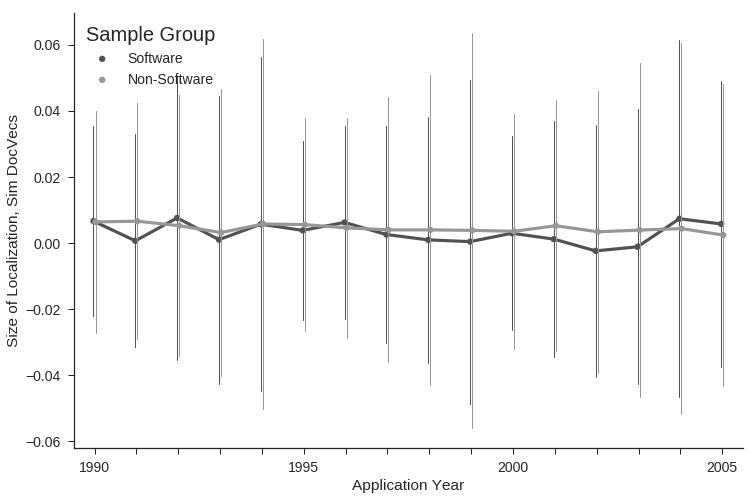

In [41]:
x1 = "tp_appyear"
y1 = c
hue1 = "samp"
order1 = None
conf_int1 = "sd"
df[x1] = df[x1].astype(int)
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])

ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])

# Get every 5 years
plt.setp(g3.get_xticklabels(), visible=False)
plt.setp(g3.get_xticklabels()[::5], visible=True)
plt.savefig(savepath+"1b-SoftwareLocalSim.png")
plt.show()
del(fig, ax)